In [ ]:
"""Project: Wine Recommendation Engine
Author: Kamil Jankowski
Contact: https://www.linkedin.com/in/kamil-jankowski-bb8b38165
Created on: April 2020

Description:
Recommendation system helps buyers to find relevant wine bottles to save their time and money.
Python algorithms build co-occurrence matrix and based on description, country, province of origin, variety, reviews (0-100 points) and price segment of wine return from database the most similar products."""

In [1]:
# Loading basic packages

import pandas as pd
import numpy as np
import matplotlib as plt
pd.set_option("display.max.columns", None)

In [3]:
# Insert the path to folder with winemag-data-130k-v2.csv on your desktop
data = pd.read_csv('C:/Users/winemag-data-130k-v2.csv', low_memory=False)
data.head()

,Unnamed: 0,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
0,0,Italy,"Aromas include tropical fruit, broom, brimston...",Vulkà Bianco,87,NaN,Sicily & Sardinia,Etna,NaN,Kerin O’Keefe,@kerinokeefe,Nicosia 2013 Vulkà Bianco (Etna),White Blend,Nicosia
1,1,Portugal,"This is ripe and fruity, a wine that is smooth...",Avidagos,87,15.0,Douro,NaN,NaN,Roger Voss,@vossroger,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos
2,2,US,"Tart and snappy, the flavors of lime flesh and...",NaN,87,14.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,Rainstorm
3,3,US,"Pineapple rind, lemon pith and orange blossom ...",Reserve Late Harvest,87,13.0,Michigan,Lake Michigan Shore,NaN,Alexander Peartree,NaN,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,St. Julian
4,4,US,"Much like the regular bottling from 2012, this...",Vintner's Reserve Wild Child Block,87,65.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks


In [4]:
# We have "nan" string values, let's remove them and copy columns which will be needed to build engines

wine = data[['title', 'country', 'description', 'points', 'price', 'province', 'variety', 'winery']]
wine = wine.query("title != 'NaN' and country != 'NaN' and description != 'NaN' and points != 'NaN' and price != 'NaN' and province != 'NaN' and variety != 'NaN' and winery != 'NaN'")
wine = wine.dropna()

In [5]:
# sort values by points
wine = wine.sort_values('points', ascending=False)
wine.head()

,title,country,description,points,price,province,variety,winery
111756,Château Léoville Las Cases 2010 Saint-Julien,France,"A hugely powerful wine, full of dark, brooding...",100,359.0,Bordeaux,Bordeaux-style Red Blend,Château Léoville Las Cases
42197,Casa Ferreirinha 2008 Barca-Velha Red (Douro),Portugal,This is the latest release of what has long be...,100,450.0,Douro,Portuguese Red,Casa Ferreirinha
89729,Salon 2006 Le Mesnil Blanc de Blancs Brut Char...,France,This new release from a great vintage for Char...,100,617.0,Champagne,Chardonnay,Salon
113929,Charles Smith 2006 Royal City Syrah (Columbia ...,US,In 2005 Charles Smith introduced three high-en...,100,80.0,Washington,Syrah,Charles Smith
7335,Avignonesi 1995 Occhio di Pernice (Vin Santo ...,Italy,Thick as molasses and dark as caramelized brow...,100,210.0,Tuscany,Prugnolo Gentile,Avignonesi


In [7]:
wine.shape

(120915, 8)

In [6]:
# We have 120 915 observations in 8 columns which is too much to calculate cosine similarity on mine (and most of us) computer so let's use only part of the original database

wine['points'].describe()
quantile = wine["points"].quantile(0.80)
wine = wine.copy().loc[wine["points"] >= quantile]
wine.shape
# Ok, we have 25% of the original database. It should be enough to prepare reliable recommendation engine. If you have more powerful computer, feel free to change used quantile


(31019, 8)

In [24]:
# Let's build the first engine which will be based on description of the wines bottles
wine["description"].head()

111756    A hugely powerful wine, full of dark, brooding...
42197     This is the latest release of what has long be...
89729     This new release from a great vintage for Char...
113929    In 2005 Charles Smith introduced three high-en...
7335      Thick as molasses and dark as caramelized brow...
Name: description, dtype: object

In [25]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [26]:
# To increase accuracy, we remove all english stop words such as 'the', 'a'
tfidf = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf.fit_transform(wine['description'])

In [27]:
from sklearn.metrics.pairwise import linear_kernel

In [11]:
# Below code will create the cosine similarity matrix which be needed to build engine.
# Be patient, calculation of it would takes a few seconds.
#If you get memory error, increase quantile value used to divide dataframe.

cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)

In [28]:
indices = pd.Series(wine.index, index=wine['title']).drop_duplicates()

In [29]:
def wine_recommendations(title, cosine_sim=cosine_sim):
    
    # fit index of the wine to the title
    idx = indices[title]
    
    # similarity score between wine which you selected and the others wines in database
    sim_scores = list(enumerate(cosine_sim[idx]))
    
    # sort results by the similarity scores
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    
    # show top 10 results with the highest similarity score
    sim_scores = sim_scores[1:11]

    # select indices
    wine_indices = [i[0] for i in sim_scores]

    # return selected wine and the recommendation results in the new dataframe
    rec1 = wine[['title', 'country', 'description', 'points', 'price', 'province', 'variety', 'winery']].iloc[wine_indices]

    frames = [wine[wine["title"] == title], rec1]
    recommendation = pd.concat(frames, keys=['x', 'y'])
    return recommendation

In [32]:
# To get recommendation, you have to use wine title which index is not higher than size of wine dataframe (for quantile = 80 it is 31019)

Recommendation = wine_recommendations('Château Mouton Rothschild 2009  Pauillac')
Recommendation

title country  \
x 1575             Château Mouton Rothschild 2009  Pauillac  France   
y 84282          Castello di Verduno 2012 Massara  (Barolo)   Italy   
  15454            Il Grappolo 2010  Brunello di Montalcino   Italy   
  97228   Boscarelli 2010 Riserva  (Vino Nobile di Monte...   Italy   
  41398           Benanti 2011 Serra della Contessa  (Etna)   Italy   
  97230   Il Molino di Grace 2010 Il Margone Gran Selezi...   Italy   
  50150   Col d'Orcia 2007 Poggio al Vento Riserva  (Bru...   Italy   
  47913         Milziade Antano 2010  Montefalco Sagrantino   Italy   
  89187                      Brezza 2012 Sarmassa  (Barolo)   Italy   
  44594        Gianni Brunelli 2011  Brunello di Montalcino   Italy   
  120856               Librandi 2011 Duca Sanfelice  (Cirò)   Italy   

                                                description  points   price  \
x 1575    The purest Cabernet Sauvignon fruit, with dark...      96  1300.0   
y 84282   This opens with a classic Nebbiolo nose of blu...      94    60.0   
  15454   Aromas recall mature dark berry, stewed plum, ...      93    50.0   
  97228   Aromas of blue flower, spiced plum, ripe berry...      93    50.0   
  41398   This gorgeous wine opens with fragrances of bl...      94    65.0   
  97230   Earthy aromas of leather, tilled soil, blue fl...      93    45.0   
  50150   Crushed berry, leather, scorched earth, carob ...      94   150.0   
  47913   Smooth and velvety, this powerfully structured...      95    50.0   
  89187   Leather, ripe berry, cured meat, chopped herb ...      92    70.0   
  44594   Classic Sangiovese aromas of tilled soil, wild...      95    56.0   
  120856  Aromas of perfumed berry, violet, leather, pip...      91    20.0   

                   province                   variety  \
x 1575             Bordeaux  Bordeaux-style Red Blend   
y 84282            Piedmont                  Nebbiolo   
  15454             Tuscany                Sangiovese   
  97228             Tuscany                 Red Blend   
  41398   Sicily & Sardinia                 Red Blend   
  97230             Tuscany                 Red Blend   
  50150             Tuscany                Sangiovese   
  47913       Central Italy                Sagrantino   
  89187            Piedmont                  Nebbiolo   
  44594             Tuscany                Sangiovese   
  120856     Southern Italy                 Gaglioppo   

                             winery  
x 1575    Château Mouton Rothschild  
y 84282         Castello di Verduno  
  15454                 Il Grappolo  
  97228                  Boscarelli  
  41398                     Benanti  
  97230          Il Molino di Grace  
  50150                 Col d'Orcia  
  47913             Milziade Antano  
  89187                      Brezza  
  44594             Gianni Brunelli  
  120856                   Librandi

In [18]:
# I don't think these are the worthful recommendations. Let's try to fix it and create new column with metadata of wine bottles

In [33]:
# Before it, we have to change price and points on strings
wine['price'] = wine['price'].astype(str) 
wine['points'] = wine['points'].astype(str)

In [35]:
# And remove duplicates in titles
wine['title'].value_counts()

Domaine Vacheron 2015  Sancerre                                                            4
Louis Roederer NV Brut Premier  (Champagne)                                                4
Charles Heidsieck NV Brut Réserve  (Champagne)                                             4
Roederer Estate NV Brut Rosé Sparkling (Anderson Valley)                                   4
Vollereaux NV Blanc de Blancs Brut Chardonnay (Champagne)                                  4
Perrier Jouët 2006 Belle Epoque Brut Rosé  (Champagne)                                     3
Mailly Grand Cru NV Brut Réserve  (Champagne)                                              3
Chambers Rosewood Vineyards NV Grand Muscat (Rutherglen)                                   3
Ruinart NV Blanc de Blancs Brut Chardonnay (Champagne)                                     3
González Byass NV Nectar Dulce Pedro Ximénez (Jerez)                                       3
Château Pape Clément 2014  Pessac-Léognan                             

In [36]:
wine[wine["title"] == "Charles Heidsieck NV Brut Réserve  (Champagne)"] # We have to be careful because some of the titles are the two or more different wine types with different prices or points

# The best way to do it is add to metadata title of the wine and the rest of the variables 

,title,country,description,points,price,province,variety,winery
23569,Charles Heidsieck NV Brut Réserve (Champagne),France,"A great wine, much more than only a Champagne,...",93,55.0,Champagne,Champagne Blend,Charles Heidsieck
96155,Charles Heidsieck NV Brut Réserve (Champagne),France,This ripe Champagne is deliciously balanced be...,92,65.0,Champagne,Champagne Blend,Charles Heidsieck
107049,Charles Heidsieck NV Brut Réserve (Champagne),France,"Balanced and rich with apple flavors, this is ...",91,65.0,Champagne,Champagne Blend,Charles Heidsieck
128775,Charles Heidsieck NV Brut Réserve (Champagne),France,"Balanced and rich with apple flavors, this is ...",91,65.0,Champagne,Champagne Blend,Charles Heidsieck


In [37]:
def metadata(x):
    return ''.join(x['country']) + '' + '' .join(x['title']) + ''.join(x['points']) + ' ' + x['price'] + ' ' + ''.join(x['province'] + ' ' + x['variety'])

In [38]:
wine['metadata'] = wine.apply(metadata, axis=1)
wine['metadata'].value_counts()
# As expected, we have couple of duplicates of not only wine title but it price, points, etc. which have to be removed from dataset

USDomaine Serene NV R Dry Rosé (Oregon)91 35.0 Oregon Rosé                                                                       3
FranceVollereaux NV Blanc de Blancs Brut Chardonnay (Champagne)91 40.0 Champagne Chardonnay                                      3
USGård 2013 Vaucluse Lawrence Vineyards Red (Columbia Valley (WA))91 35.0 Washington Red Blend                                   2
SpainBodegas Leda 2008 Leda Viñas Viejas Tempranillo (Vino de la Tierra de Castilla y León)92 45.0 Northern Spain Tempranillo    2
USMerry Edwards 2011 Olivet Lane Pinot Noir (Russian River Valley)92 62.0 California Pinot Noir                                  2
USPatz & Hall 2015 Dutton Ranch Chardonnay (Russian River Valley)94 44.0 California Chardonnay                                   2
USMatanzas Creek 2006 Sauvignon Blanc (Sonoma County)91 24.0 California Sauvignon Blanc                                          2
PortugalDFJ Vinhos 2013 Consensus Pinot Noir-Touriga Nacional Red (Lisboa)91 19.0 L

In [39]:
wine = wine.drop_duplicates('metadata')
wine['metadata'].value_counts()
# It's done.

FranceJean Biecher & Fils 2016 Schoenenbourg Grand Cru Riesling (Alsace)93 45.0 Alsace Riesling                                                 1
FranceLelarge-Pugeot 2005 Millésime Premier Cru Extra Brut  (Champagne)93 64.0 Champagne Champagne Blend                                        1
USCa' Del Grevino 2014 Estate Vineyards White Riesling (Santa Maria Valley)91 60.0 California Riesling                                          1
AustraliaJacob's Creek 1998 Limited Release Shiraz-Cabernet Sauvignon (South Australia)92 50.0 South Australia Shiraz-Cabernet Sauvignon        1
USBonaccorsi 2008 Pinot Noir (Sta. Rita Hills)91 40.0 California Pinot Noir                                                                     1
ItalyDamilano 2012 Lecinquevigne  (Barolo)91 50.0 Piedmont Nebbiolo                                                                             1
IsraelPsagot 2012 Cabernet Sauvignon (Judean Hills)92 30.0 Judean Hills Cabernet Sauvignon                                  

In [40]:
# We can remove the title from metadata column
def metadata(x):
    return ''.join(x['country']) + ' ' + ''.join(x['points']) + ' ' + x['price'] + ' ' + ''.join(x['province'] + ' ' + x['variety'])

In [41]:
wine['metadata'] = wine.apply(metadata, axis=1)
wine['metadata'].head() # It looks fine, we have all information in one column

111756    France 100 359.0 Bordeaux Bordeaux-style Red B...
42197               Portugal 100 450.0 Douro Portuguese Red
89729                 France 100 617.0 Champagne Chardonnay
113929                         US 100 80.0 Washington Syrah
7335               Italy 100 210.0 Tuscany Prugnolo Gentile
Name: metadata, dtype: object

In [42]:
from sklearn.feature_extraction.text import CountVectorizer

In [43]:
# Once again we will remove from the column all english stop words and repeat previous steps
count = CountVectorizer(stop_words='english')
count_matrix = count.fit_transform(wine['metadata']) 

In [44]:
from sklearn.metrics.pairwise import cosine_similarity

In [45]:
cosine_sim = cosine_similarity(count_matrix, count_matrix)

In [46]:
wine = wine.reset_index()
indices = pd.Series(wine.index, index=wine['title'])
wine = wine[['title', 'country', 'description', 'points', 'price', 'province', 'variety', 'winery', 'metadata']]

In [32]:
# We base on different similary matrix so we have to rebuild our recommendation's def

In [47]:
def wine_recommendations(title, cosine_sim=cosine_sim):
    
    # fit index of the wine to the title
    idx = indices[title]
    
    # similarity score between wine which you selected and the others wines in database
    sim_scores = list(enumerate(cosine_sim[idx]))
    
    # sort results by the similarity scores
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    
    # show top 10 results with the highest similarity score
    sim_scores = sim_scores[1:11]

    # select indices
    wine_indices = [i[0] for i in sim_scores]

    # return selected wine and the recommendation results in the new dataframe
    recommendation = wine[['title', 'country', 'description', 'points', 'price', 'province', 'variety', 'winery', 'metadata']].iloc[wine_indices]

    frames = [wine[wine["title"] == title], recommendation]
    recommendation = pd.concat(frames, keys=['x', 'y'])
    return recommendation

In [34]:
Recommendation = wine_recommendations('Château Palmer 2009  Margaux')
Recommendation

title country  \
x 82                     Château Palmer 2009  Margaux  France   
y 83                    Château Margaux 2009  Margaux  France   
  92     Château Léoville Poyferré 2010  Saint-Julien  France   
  100   Château Léoville Las Cases 2009  Saint-Julien  France   
  6138        Château Vray Croix de Gay 2009  Pomerol  France   
  52                     Château Climens 2014  Barsac  France   
  89          Château Haut-Brion 2007  Pessac-Léognan  France   
  0     Château Léoville Las Cases 2010  Saint-Julien  France   
  5        Château Léoville Barton 2010  Saint-Julien  France   
  9          Château Lafite Rothschild 2010  Pauillac  France   
  16         Château Cheval Blanc 2010  Saint-Émilion  France   

                                              description points   price  \
x 82    A beautiful wine, with the firmest tannins sur...     98   380.0   
y 83    A massive wine for Margaux, packed with tannin...     98  1900.0   
  92    A wine of architectural strength and classical...     98    92.0   
  100   A beautifully structured wine, with its tannin...     98   360.0   
  6138  Powerful tannins give this wine its dense, con...     93    98.0   
  52    This is beautully concentrated and full of gre...     98    70.0   
  89    The palate opens slowly, offering an initial c...     98   800.0   
  0     A hugely powerful wine, full of dark, brooding...    100   359.0   
  5     This is a magnificently solid wine, initially ...    100   150.0   
  9     Almost black in color, this stunning wine is g...    100  1500.0   
  16    This is the finest Cheval Blanc for many years...    100  1500.0   

        province                     variety                      winery  \
x 82    Bordeaux    Bordeaux-style Red Blend              Château Palmer   
y 83    Bordeaux    Bordeaux-style Red Blend             Château Margaux   
  92    Bordeaux    Bordeaux-style Red Blend   Château Léoville Poyferré   
  100   Bordeaux    Bordeaux-style Red Blend  Château Léoville Las Cases   
  6138  Bordeaux    Bordeaux-style Red Blend   Château Vray Croix de Gay   
  52    Bordeaux  Bordeaux-style White Blend             Château Climens   
  89    Bordeaux  Bordeaux-style White Blend          Château Haut-Brion   
  0     Bordeaux    Bordeaux-style Red Blend  Château Léoville Las Cases   
  5     Bordeaux    Bordeaux-style Red Blend     Château Léoville Barton   
  9     Bordeaux    Bordeaux-style Red Blend   Château Lafite Rothschild   
  16    Bordeaux    Bordeaux-style Red Blend        Château Cheval Blanc   

                                                 metadata  
x 82    France 98 380.0 Bordeaux Bordeaux-style Red Blend  
y 83    France 98 1900.0 Bordeaux Bordeaux-style Red B...  
  92     France 98 92.0 Bordeaux Bordeaux-style Red Blend  
  100   France 98 360.0 Bordeaux Bordeaux-style Red Blend  
  6138   France 93 98.0 Bordeaux Bordeaux-style Red Blend  
  52    France 98 70.0 Bordeaux Bordeaux-style White B...  
  89    France 98 800.0 Bordeaux Bordeaux-style White ...  
  0     France 100 359.0 Bordeaux Bordeaux-style Red B...  
  5     France 100 150.0 Bordeaux Bordeaux-style Red B...  
  9     France 100 1500.0 Bordeaux Bordeaux-style Red ...  
  16    France 100 1500.0 Bordeaux Bordeaux-style Red ...

In [ ]:
"""
Ok, as expected, we have much better recommendations but I think they are too accurate.
It's more like "show me the substitute of the wine" not "show me the similar wines".
We can try to use less metadas and add price segment instead price.

Price segment - what is it?
I don't want to have in dataframe prices such as 30.00 USD or 31.00 USD. I prefer to describe it as one of the segment, in this case it would be "Low-Price".
I know that for you it could be strange that 30 USD per wine bottle is Low-Price but we have only the best wines and the highest price is 2500 USD so...
"""

In [48]:
# Before we create price segments, we have to change type of price from string to float

wine['price'] = wine['price'].astype(float)
wine["price"].dtype

dtype('float64')

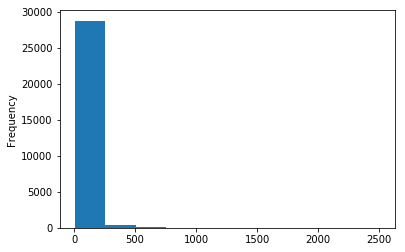

In [50]:
wine["price"].plot(kind='hist')

# We have a lot of "cheap" wine bottles and only a few of prestige. Let's create 8 price buckets.

In [51]:
pd.qcut(wine["price"], q=8)

0        (90.0, 2500.0]
1        (90.0, 2500.0]
2        (90.0, 2500.0]
3          (69.0, 90.0]
4        (90.0, 2500.0]
5        (90.0, 2500.0]
6        (90.0, 2500.0]
7        (90.0, 2500.0]
8          (69.0, 90.0]
9        (90.0, 2500.0]
10       (90.0, 2500.0]
11       (90.0, 2500.0]
12       (90.0, 2500.0]
13       (90.0, 2500.0]
14       (90.0, 2500.0]
15       (90.0, 2500.0]
16       (90.0, 2500.0]
17       (90.0, 2500.0]
18       (90.0, 2500.0]
19         (40.0, 48.0]
20       (90.0, 2500.0]
21         (69.0, 90.0]
22       (90.0, 2500.0]
23       (90.0, 2500.0]
24         (69.0, 90.0]
25       (90.0, 2500.0]
26       (90.0, 2500.0]
27       (90.0, 2500.0]
28       (90.0, 2500.0]
29       (90.0, 2500.0]
              ...      
29138     (6.999, 25.0]
29139      (55.0, 69.0]
29140      (40.0, 48.0]
29141      (55.0, 69.0]
29142      (48.0, 55.0]
29143      (33.0, 40.0]
29144     (6.999, 25.0]
29145    (90.0, 2500.0]
29146      (33.0, 40.0]
29147      (69.0, 90.0]
29148      (25.0

In [ ]:
# Above code suggests us range of each bucket. It would works if we want to have the same number of observations in every bucket (price segment) but we don't so let's modify it a little but base on it

In [52]:
# Some useful statistics
np.std(wine["price"])

67.15739715287923

In [53]:
wine["price"].mean()

60.985977783872734

In [ ]:
"""  
So I decided to use these ranges:
    - Low-Price [0 - 30.0]
    - Value (30.0 - 55.0]
    - Standard (55.0 - 80.0]
    - Premium (80.0 - 120.0]
    - Super Premium (120.0 - 250.0]
    - Ultra Premium (250.0 - 500.0]
    - Prestige (500.0 - 1000.00]
    - Prestige Plus (1000.0 - 2500.0]
"""

In [54]:
# We will work on copy of price column
wine["price segment"] = wine["price"]

In [55]:
# Loop which change price on the right price segment
segment = []

for row in wine["price segment"]:
    if row < 30:
        segment.append('LowPrice')
    elif row < 55:
        segment.append('Value')
    elif row < 80:
        segment.append('Standard')
    elif row < 120:
        segment.append('Premium')
    elif row < 250:
        segment.append('SuperPremium')
    elif row < 500:
        segment.append('UltraPremium')
    elif row < 1000:
        segment.append('Prestige')
    elif row >= 1000:
        segment.append('PrestigePlus')
    else:
        segment.append('Error')
        
wine['price segment'] = segment

In [56]:
wine['price segment'].value_counts()
# No Errors, great!

Value           11993
Standard         6483
LowPrice         5438
Premium          3122
SuperPremium     1669
UltraPremium      364
Prestige           84
PrestigePlus       15
Name: price segment, dtype: int64

In [57]:
# We have to rebuild our metadata

def metadata(x):
    return ''.join(x['country']) + ' ' + ''.join(x['points']) + ' ' + x['price segment'] + ' ' + ''.join(x['province'] + ' ' + x['variety'])


In [58]:
wine['metadata'] = wine.apply(metadata, axis=1)

In [59]:
# Once again we have to create the new similarity matrix
count = CountVectorizer(stop_words='english')
count_matrix = count.fit_transform(wine['metadata']) 

In [60]:
cosine_sim = cosine_similarity(count_matrix, count_matrix)

In [61]:
wine = wine.reset_index()
indices = pd.Series(wine.index, index=wine['title'])

In [62]:
wine = wine[['title', 'country', 'description', 'points', 'price', 'price segment', 'province', 'variety', 'winery', 'metadata']]

In [63]:
# New recommendation's def

def wine_recommendations(title, cosine_sim=cosine_sim):
    
    # fit index of the wine to the title
    idx = indices[title]
    
    # similarity score between wine which you selected and the others wines in database
    sim_scores = list(enumerate(cosine_sim[idx]))
    
    # sort results by the similarity scores
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    
    # show top 10 results with the highest similarity score
    sim_scores = sim_scores[1:11]

    # select indices
    wine_indices = [i[0] for i in sim_scores]

    # return selected wine and the recommendation results in the new dataframe
    recommendation = wine[['title', 'country', 'description', 'points', 'price', 'price segment', 'province', 'variety', 'winery', 'metadata']].iloc[wine_indices]

    frames = [wine[wine["title"] == title], recommendation]
    recommendation = pd.concat(frames, keys=['x', 'y'])
    return recommendation

In [64]:
Recommendation = wine_recommendations('Château Mouton Rothschild 2009  Pauillac')
Recommendation

title country  \
x 771         Château Mouton Rothschild 2009  Pauillac  France   
y 759          Château Haut-Brion 2009  Pessac-Léognan  France   
  771         Château Mouton Rothschild 2009  Pauillac  France   
  330         Château Mouton Rothschild 2014  Pauillac  France   
  364         Château Cheval Blanc 2014  Saint-Émilion  France   
  368              Château Pontet-Canet 2014  Pauillac  France   
  371                      Le Dôme 2014  Saint-Émilion  France   
  376           Château Valandraud 2014  Saint-Émilion  France   
  378       Château Bélair-Monange 2014  Saint-Émilion  France   
  379  Château Smith Haut Lafitte 2014  Pessac-Léognan  France   
  389     Château Ducru Beaucaillou 2014  Saint-Julien  France   

                                             description points   price  \
x 771  The purest Cabernet Sauvignon fruit, with dark...     96  1300.0   
y 759  Solid, very structured, packed with dense and ...     96  1200.0   
  771  The purest Cabernet Sauvignon fruit, with dark...     96  1300.0   
  330  The label of this vintage is designed by David...     96   400.0   
  364  With its high proportion of Cabernet Franc (45...     96   475.0   
  368  This is a finely structured wine with dark tan...     96   110.0   
  371  This almost 100% Cabernet Franc single-vineyar...     96   175.0   
  376  Here's an impressive wine that is so ripe and ...     96   200.0   
  378  With the amalgamation of Château Magdelaine in...     96   160.0   
  379  This is a powerful wine, made to age for a lon...     96    75.0   
  389  This powerful wine has a superb mix of the cri...     96   130.0   

      price segment  province                   variety  \
x 771  PrestigePlus  Bordeaux  Bordeaux-style Red Blend   
y 759  PrestigePlus  Bordeaux  Bordeaux-style Red Blend   
  771  PrestigePlus  Bordeaux  Bordeaux-style Red Blend   
  330  UltraPremium  Bordeaux  Bordeaux-style Red Blend   
  364  UltraPremium  Bordeaux  Bordeaux-style Red Blend   
  368       Premium  Bordeaux  Bordeaux-style Red Blend   
  371  SuperPremium  Bordeaux  Bordeaux-style Red Blend   
  376  SuperPremium  Bordeaux  Bordeaux-style Red Blend   
  378  SuperPremium  Bordeaux  Bordeaux-style Red Blend   
  379      Standard  Bordeaux  Bordeaux-style Red Blend   
  389  SuperPremium  Bordeaux  Bordeaux-style Red Blend   

                           winery  \
x 771   Château Mouton Rothschild   
y 759          Château Haut-Brion   
  771   Château Mouton Rothschild   
  330   Château Mouton Rothschild   
  364        Château Cheval Blanc   
  368        Château Pontet-Canet   
  371                     Le Dôme   
  376          Château Valandraud   
  378      Château Bélair-Monange   
  379  Château Smith Haut Lafitte   
  389   Château Ducru Beaucaillou   

                                                metadata  
x 771  France 96 PrestigePlus Bordeaux Bordeaux-style...  
y 759  France 96 PrestigePlus Bordeaux Bordeaux-style...  
  771  France 96 PrestigePlus Bordeaux Bordeaux-style...  
  330  France 96 UltraPremium Bordeaux Bordeaux-style...  
  364  France 96 UltraPremium Bordeaux Bordeaux-style...  
  368  France 96 Premium Bordeaux Bordeaux-style Red ...  
  371  France 96 SuperPremium Bordeaux Bordeaux-style...  
  376  France 96 SuperPremium Bordeaux Bordeaux-style...  
  378  France 96 SuperPremium Bordeaux Bordeaux-style...  
  379  France 96 Standard Bordeaux Bordeaux-style Red...  
  389  France 96 SuperPremium Bordeaux Bordeaux-style...

In [ ]:
# Not a big difference so we can try to limit metadata to the most important to have more varied recommendations. Let's modify the previous step.

In [65]:
def metadata(x):
    return ''.join(x['points']) + ' ' + x['price segment'] + ' ' + x['variety']

In [66]:
wine['metadata'] = wine.apply(metadata, axis=1)
count = CountVectorizer(stop_words='english')
count_matrix = count.fit_transform(wine['metadata']) 

In [67]:
cosine_sim = cosine_similarity(count_matrix, count_matrix)

In [68]:
wine = wine.reset_index()
indices = pd.Series(wine.index, index=wine['title'])

In [69]:
wine = wine[['title', 'country', 'description', 'points', 'price', 'price segment', 'province', 'variety', 'winery', 'metadata']]

In [71]:
def wine_recommendations(title, cosine_sim=cosine_sim):
    
    # fit index of the wine to the title
    idx = indices[title]
    
    # similarity score between wine which you selected and the others wines in database
    sim_scores = list(enumerate(cosine_sim[idx]))
    
    # sort results by the similarity scores
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    
    # show top 10 results with the highest similarity score
    sim_scores = sim_scores[1:11]

    # select indices
    wine_indices = [i[0] for i in sim_scores]

    # return selected wine and the recommendation results in the new dataframe
    recommendation = wine[['title', 'country', 'description', 'points', 'price', 'price segment', 'province', 'variety', 'winery', 'metadata']].iloc[wine_indices]

    frames = [wine[wine["title"] == title], recommendation]
    recommendation = pd.concat(frames, keys=['x', 'y'])
    return recommendation

In [72]:
Recommendation = wine_recommendations('Château Mouton Rothschild 2009  Pauillac')
Recommendation

title country  \
x 771           Château Mouton Rothschild 2009  Pauillac  France   
y 759            Château Haut-Brion 2009  Pessac-Léognan  France   
  771           Château Mouton Rothschild 2009  Pauillac  France   
  9             Château Lafite Rothschild 2010  Pauillac  France   
  16            Château Cheval Blanc 2010  Saint-Émilion  France   
  83                       Château Margaux 2009  Margaux  France   
  122  Château La Mission Haut-Brion 2009  Pessac-Léo...  France   
  293                       Château Pétrus 2011  Pomerol  France   
  326   Portfolio 2013 Limited Edition Red (Napa Valley)      US   
  330           Château Mouton Rothschild 2014  Pauillac  France   
  364           Château Cheval Blanc 2014  Saint-Émilion  France   

                                             description points   price  \
x 771  The purest Cabernet Sauvignon fruit, with dark...     96  1300.0   
y 759  Solid, very structured, packed with dense and ...     96  1200.0   
  771  The purest Cabernet Sauvignon fruit, with dark...     96  1300.0   
  9    Almost black in color, this stunning wine is g...    100  1500.0   
  16   This is the finest Cheval Blanc for many years...    100  1500.0   
  83   A massive wine for Margaux, packed with tannin...     98  1900.0   
  122  Such a generous and ripe wine, with a dark cor...     97  1100.0   
  293  This extravagantly perfumed wine has great jui...     97  2000.0   
  326  Robert Mondavi winemaker Genevieve Janssens ma...     96   155.0   
  330  The label of this vintage is designed by David...     96   400.0   
  364  With its high proportion of Cabernet Franc (45...     96   475.0   

      price segment    province                   variety  \
x 771  PrestigePlus    Bordeaux  Bordeaux-style Red Blend   
y 759  PrestigePlus    Bordeaux  Bordeaux-style Red Blend   
  771  PrestigePlus    Bordeaux  Bordeaux-style Red Blend   
  9    PrestigePlus    Bordeaux  Bordeaux-style Red Blend   
  16   PrestigePlus    Bordeaux  Bordeaux-style Red Blend   
  83   PrestigePlus    Bordeaux  Bordeaux-style Red Blend   
  122  PrestigePlus    Bordeaux  Bordeaux-style Red Blend   
  293  PrestigePlus    Bordeaux  Bordeaux-style Red Blend   
  326  SuperPremium  California  Bordeaux-style Red Blend   
  330  UltraPremium    Bordeaux  Bordeaux-style Red Blend   
  364  UltraPremium    Bordeaux  Bordeaux-style Red Blend   

                              winery  \
x 771      Château Mouton Rothschild   
y 759             Château Haut-Brion   
  771      Château Mouton Rothschild   
  9        Château Lafite Rothschild   
  16            Château Cheval Blanc   
  83                 Château Margaux   
  122  Château La Mission Haut-Brion   
  293                 Château Pétrus   
  326                      Portfolio   
  330      Château Mouton Rothschild   
  364           Château Cheval Blanc   

                                        metadata  
x 771   96 PrestigePlus Bordeaux-style Red Blend  
y 759   96 PrestigePlus Bordeaux-style Red Blend  
  771   96 PrestigePlus Bordeaux-style Red Blend  
  9    100 PrestigePlus Bordeaux-style Red Blend  
  16   100 PrestigePlus Bordeaux-style Red Blend  
  83    98 PrestigePlus Bordeaux-style Red Blend  
  122   97 PrestigePlus Bordeaux-style Red Blend  
  293   97 PrestigePlus Bordeaux-style Red Blend  
  326   96 SuperPremium Bordeaux-style Red Blend  
  330   96 UltraPremium Bordeaux-style Red Blend  
  364   96 UltraPremium Bordeaux-style Red Blend

In [ ]:

"""
Now I am happy with the recommendations which we created. As you see, Château Mouton Rothschild 2009 Pauillac has a lot of positive reviews (96 points) but it is expensive wine (1300 USD per bottle) and not so many people could afford to buy it. Thanks to the latest version of the engine, we found alternatives which are Portfolio 2013 Limited Edition Red (Napa Valley) (155 USD per bottle) and Château Mouton Rothschild 2014 Pauillac (400 USD per bottle). Before you will buy Château Mouton Rothschild 2009 Pauillac for 1300 USD, take a look on the same wine from 2010 which has the best reviews (100 points!) and the price is "only" 200 USD higher.

Kamil Jankowski
Stay in touch: https://www.linkedin.com/in/kamil-jankowski-bb8b38165

""'